In [1]:
#Importing the necessary libraries:
import cv2 as cv
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import os
from sklearn.model_selection import cross_val_score

In [2]:
#Initializing the values needed for all the image files
normaldir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
tbdir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'
images = []
labels = []
imagesize = 224

In [3]:
#Storing all the image directories in the 'images' array and corresponding them to either 1 for TB images or 0 for normal images.
for x in os.listdir(normaldir):
    imagedir = os.path.join(normaldir, x)
    image = cv.imread(imagedir, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (imagesize, imagesize))
    images.append(image)
    labels.append(0)
    
for y in os.listdir(tbdir):
    imagedir = os.path.join(tbdir, y)
    image = cv.imread(imagedir, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (imagesize, imagesize))
    images.append(image)
    labels.append(1)

In [4]:
#Converting to NumPy arrays since they have more features than regular lists
images = np.array(images)
labels = np.array(labels)

#Splitting the images and labels into training and testing sets, then normalizing the values within them for computational efficiency (from 0-255 scale to 0-1 scale)
imagetrain, imagetest, label_train, label_test = train_test_split(images, labels, test_size=0.3, random_state=42)
image_train = (imagetrain.astype('float32')) / 255.0
image_test = (imagetest.astype('float32')) / 255.0

In [5]:
num_images = imagetrain.size // (imagesize * imagesize * 3)
print(num_images)

2940


In [6]:
# #Flattening the image array into 2D (making it [2940 images] x [all the pixels of the image in just one 1D array]) to be suitable for SMOTE oversampling
# imagetrain = imagetrain.reshape(num_images, (imagesize*imagesize*3))

# #Performing oversampling
# smote = SMOTE(random_state=42)
# imagetrain, labeltrain = smote.fit_resample(imagetrain, labeltrain)

# #Unflattening the images now to use them for convolutional neural network (4914 images of 256x256 size, with 1 color channel (grayscale, as compared to RGB with 3 color channels))
# imagetrain = imagetrain.reshape(-1, imagesize, imagesize, 3)
# print(imagetrain.shape)

In [7]:
#Classes balanced - equal counts of each label
# print(np.unique(labeltrain, return_counts=True))

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# VGG16

In [9]:
#Importing the necessary libraries
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
from keras.applications.vgg16 import VGG16
conv_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
conv_base.trainable = True

In [12]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras import Sequential
# Create the Sequential model and add the conv_base and FC layers
model = Sequential()
model.add(conv_base)
model.add(Flatten())

# Adding fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding dropout to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding another dropout layer
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

In [14]:
#Compiling the model with parameters best suited for the task at hand:
model.compile(
    loss='binary_crossentropy', #Best for binary classification
    optimizer = keras.optimizers.Adam(learning_rate=0.001), #Good starting LR for dataset of this size
    metrics=['accuracy'], #Looking for accuracy
)

In [15]:
#Fitting the model, with the ReduceLROnPlateau callback added to it to reduce the learning rate to take smaller steps in increasing the accuracy whenever the learning rate plateaus (goes in the wrong direction)
#Doing this with patience=1, meaning it will perform this if it even plateaus for one epoch, since only 10 epochs are used
#factor=0.1 means that for every time the learning rate is reduced, it is reduced by a factor of 0.1 - it also won't go lower than 0.00001
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

#Fitting the model w/ the callback. ON VS CODE, batch size of 16 makes each epoch take around a minute in this case w/ good accuracy, making the whole training process 10 min, but on Kaggle it should take longer due to less computational resources:
history = model.fit(image_train, label_train, batch_size=16, epochs=10, verbose=2, callbacks = [reduce_lr],validation_split=0.2)

Epoch 1/10


I0000 00:00:1730650144.876279      85 service.cc:145] XLA service 0x789460009350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730650144.876370      85 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730650144.876379      85 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730650171.471305      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 - 69s - 470ms/step - accuracy: 0.8206 - loss: 0.6295 - val_accuracy: 0.8367 - val_loss: 0.4436 - learning_rate: 0.0010
Epoch 2/10
147/147 - 31s - 211ms/step - accuracy: 0.8219 - loss: 0.5231 - val_accuracy: 0.8367 - val_loss: 0.4612 - learning_rate: 0.0010
Epoch 3/10
147/147 - 32s - 217ms/step - accuracy: 0.8312 - loss: 0.4750 - val_accuracy: 0.8367 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 4/10
147/147 - 33s - 222ms/step - accuracy: 0.8333 - loss: 0.4759 - val_accuracy: 0.8367 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 5/10
147/147 - 32s - 217ms/step - accuracy: 0.8346 - loss: 0.5347 - val_accuracy: 0.8367 - val_loss: 0.5115 - learning_rate: 0.0010
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
147/147 - 32s - 218ms/step - accuracy: 0.8333 - loss: 0.6641 - val_accuracy: 0.8367 - val_loss: 0.4580 - learning_rate: 0.0010
Epoch 7/10
147/147 - 32s - 218ms/step - accuracy: 0.8355 - loss: 0.4663 - val_accuracy: 0.8367 - val_loss

In [16]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8370 - loss: 0.4545
Loss of the model is -  0.46623244881629944
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8370 - loss: 0.4545
Accuracy of the model is -  82.77778029441833 %


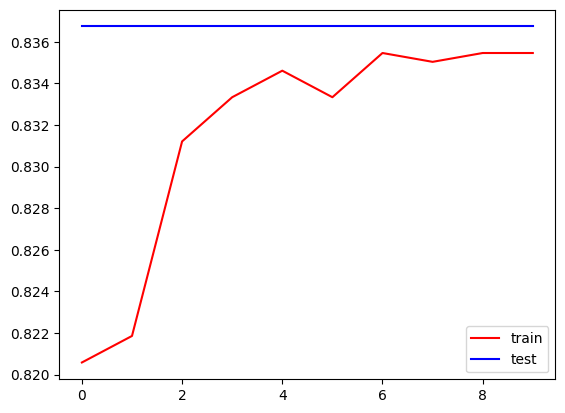

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

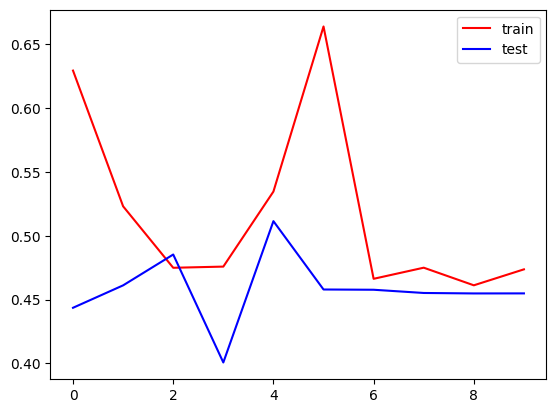

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [19]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 5s - 118ms/step - accuracy: 0.8278 - loss: 0.4662
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1043
           1       0.00      0.00      0.00       217

    accuracy                           0.83      1260
   macro avg       0.41      0.50      0.45      1260
weighted avg       0.69      0.83      0.75      1260

----CONFUSION MATRICS----
[[1043    0]
 [ 217    0]]


# ResNet-50


In [20]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

conv_base.trainable = True

model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=15, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1730650608.755948      85 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_29', 20 bytes spill stores, 20 bytes spill loads



74/74 - 121s - 2s/step - accuracy: 0.9311 - loss: 1.3725 - val_accuracy: 0.8367 - val_loss: 24979788.0000 - learning_rate: 0.0010
Epoch 2/15

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 23s - 308ms/step - accuracy: 0.9264 - loss: 0.3861 - val_accuracy: 0.1633 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 3/15
74/74 - 23s - 306ms/step - accuracy: 0.9469 - loss: 4.9248 - val_accuracy: 0.1633 - val_loss: 0.7337 - learning_rate: 1.0000e-04
Epoch 4/15
74/74 - 22s - 298ms/step - accuracy: 0.9690 - loss: 0.1867 - val_accuracy: 0.1633 - val_loss: 0.7485 - learning_rate: 1.0000e-04
Epoch 5/15
74/74 - 22s - 299ms/step - accuracy: 0.9728 - loss: 0.1374 - val_accuracy: 0.1633 - val_loss: 0.7537 - learning_rate: 1.0000e-04
Epoch 6/15
74/74 - 22s - 302ms/step - accuracy: 0.9817 - loss: 0.0735 - val_accuracy: 0.1633 - val_loss: 0.7558 - learning_rate: 1.0000e-04
Epoch 7/15
74/74 - 22s - 300ms/step - accuracy: 0.9847 - loss: 0.0586 - val_accuracy: 0.1633 - v

In [21]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8755 - loss: 0.3618
Loss of the model is -  0.38554462790489197
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8755 - loss: 0.3618
Accuracy of the model is -  86.98412775993347 %


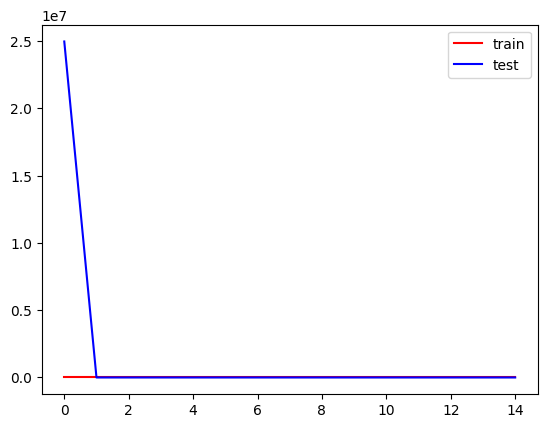

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

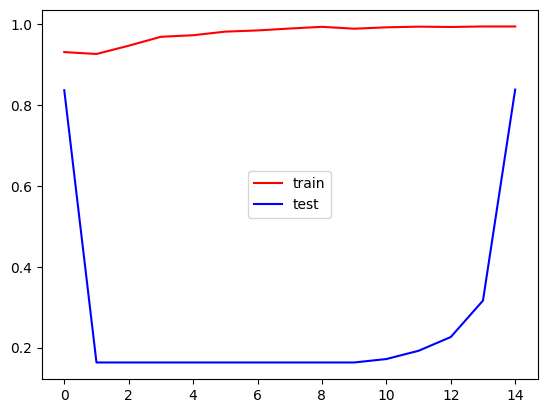

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

In [25]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 3s - 81ms/step - accuracy: 0.8698 - loss: 0.3855
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1043
           1       0.57      0.98      0.72       217

    accuracy                           0.87      1260
   macro avg       0.78      0.91      0.82      1260
weighted avg       0.92      0.87      0.88      1260

----CONFUSION MATRICS----
[[883 160]
 [  4 213]]


# DenseNet121

In [26]:
from keras.applications import DenseNet121

conv_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
conv_base.trainable = True

model = Sequential([
    conv_base,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=15, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
74/74 - 282s - 4s/step - accuracy: 0.8299 - loss: 0.6871 - val_accuracy: 0.8367 - val_loss: 6422.9482 - learning_rate: 0.0010
Epoch 2/15
74/74 - 23s - 304ms/step - accuracy: 0.8954 - loss: 0.2819 - val_accuracy: 0.4694 - val_loss: 1.0055 - learning_rate: 0.0010
Epoch 3/15
74/74 - 23s - 304ms/step - accuracy: 0.9252 - loss: 0.1508 - val_accuracy: 0.6905 - val_loss: 1.8809 - learning_rate: 0.0010
Epoch 4/15
74/74 - 22s - 298ms/step - accuracy: 0.9566 - loss: 0.1230 - val_accuracy: 0.8776 - val_loss: 11.6495 - learning_rate: 0.0010
Epoch 5/15
74/74 - 22s - 297ms/step - accuracy: 0.9592 - loss: 0.1081 - val_accuracy: 0.9711 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 6/15
74/74 - 22s - 301ms/step - accuracy: 0.9719 - loss: 0.0805 - val_accuracy: 0.9167 - val_loss: 0.1695 - learning_rate: 0.0010
Epoch 7/15
74/74 - 22s - 300ms/step - accuracy: 0.9792 - loss: 0.0542 - val_accuracy: 0.6803 - val_loss: 1.9955 - learning_rate: 0.

In [27]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9963 - loss: 0.0146
Loss of the model is -  0.010844607837498188
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9963 - loss: 0.0146
Accuracy of the model is -  99.76190328598022 %


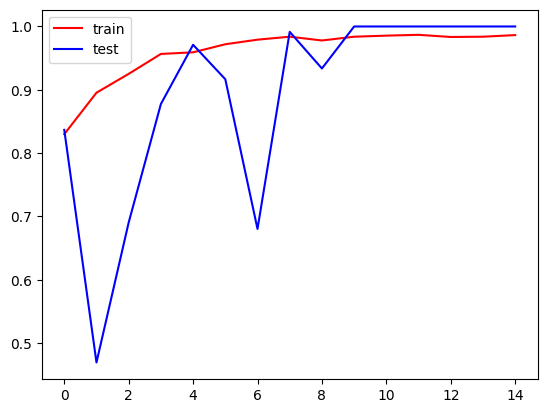

In [28]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

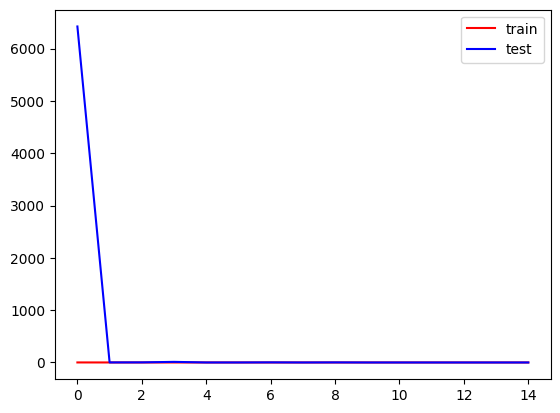

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [31]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 3s - 72ms/step - accuracy: 0.9976 - loss: 0.0108
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1043
           1       1.00      0.99      0.99       217

    accuracy                           1.00      1260
   macro avg       1.00      0.99      1.00      1260
weighted avg       1.00      1.00      1.00      1260

----CONFUSION MATRICS----
[[1043    0]
 [   3  214]]


# InceptionV3

In [32]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
conv_base.trainable = True

model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=10, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
74/74 - 147s - 2s/step - accuracy: 0.8741 - loss: 0.5331 - val_accuracy: 0.8418 - val_loss: 948.2114 - learning_rate: 0.0010
Epoch 2/10
74/74 - 18s - 240ms/step - accuracy: 0.8767 - loss: 1.3678 - val_accuracy: 0.8316 - val_loss: 20.4921 - learning_rate: 0.0010
Epoch 3/10
74/74 - 18s - 240ms/step - accuracy: 0.9171 - loss: 0.3325 - val_accuracy: 0.8844 - val_loss: 137.2725 - learning_rate: 0.0010
Epoch 4/10
74/74 - 17s - 235ms/step - accuracy: 0.9405 - loss: 0.1682 - val_accuracy: 0.9490 - val_loss: 2.4983 - learning_rate: 0.0010
Epoch 5/10
74/74 - 17s - 232ms/step - accuracy: 0.9677 - loss: 0.1098 - val_accuracy: 0.9592 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 6/10
74/74 - 17s - 234ms/step - accuracy: 0.9800 - loss: 0.0921 - val_accuracy: 0.9762 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 7/10
74/74 - 17s - 236ms/step - accuracy: 0.9851 - loss: 0.0598 - val_accuracy: 0.7738 - val_loss: 0.7423 - learning_rate: 0

In [33]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9869 - loss: 0.0407
Loss of the model is -  0.03316260874271393
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9869 - loss: 0.0407
Accuracy of the model is -  98.73015880584717 %


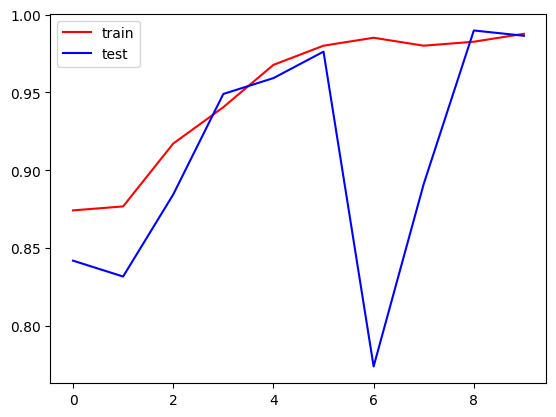

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

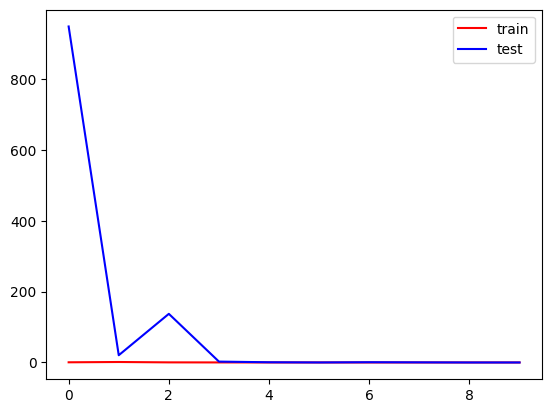

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [36]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 2s - 62ms/step - accuracy: 0.9873 - loss: 0.0332
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1043
           1       0.99      0.94      0.96       217

    accuracy                           0.99      1260
   macro avg       0.99      0.97      0.98      1260
weighted avg       0.99      0.99      0.99      1260

----CONFUSION MATRICS----
[[1040    3]
 [  13  204]]


# Lenet-5

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=10, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


Epoch 1/10
74/74 - 10s - 134ms/step - accuracy: 0.8907 - loss: 0.2540 - val_accuracy: 0.9694 - val_loss: 0.1167 - learning_rate: 0.0010
Epoch 2/10
74/74 - 2s - 22ms/step - accuracy: 0.9554 - loss: 0.1172 - val_accuracy: 0.9609 - val_loss: 0.1089 - learning_rate: 0.0010
Epoch 3/10
74/74 - 2s - 23ms/step - accuracy: 0.9719 - loss: 0.0798 - val_accuracy: 0.9337 - val_loss: 0.1755 - learning_rate: 0.0010
Epoch 4/10
74/74 - 2s - 23ms/step - accuracy: 0.9753 - loss: 0.0555 - val_accuracy: 0.9609 - val_loss: 0.1543 - learning_rate: 0.0010
Epoch 5/10
74/74 - 2s - 23ms/step - accuracy: 0.9923 - loss: 0.0270 - val_accuracy: 0.9813 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 2s - 22ms/step - accuracy: 0.9681 - loss: 0.0937 - val_accuracy: 0.9558 - val_loss: 0.1393 - learning_rate: 0.0010
Epoch 7/10

Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
74/74 - 2s - 22ms/step - ac

In [38]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9721 - loss: 0.1147
Loss of the model is -  0.11382206529378891
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9721 - loss: 0.1147
Accuracy of the model is -  97.14285731315613 %


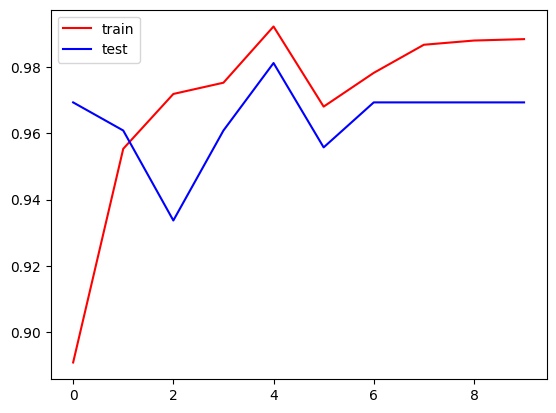

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

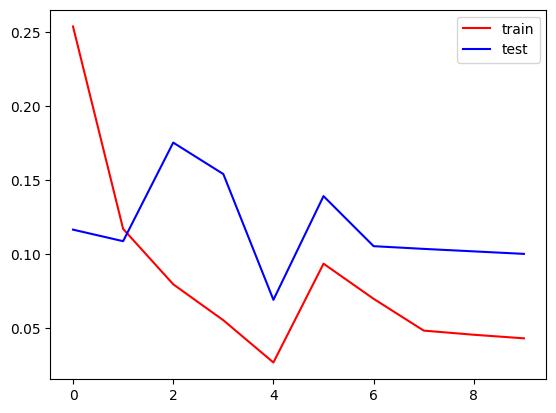

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [41]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 1s - 13ms/step - accuracy: 0.9714 - loss: 0.1138
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1043
           1       0.95      0.88      0.91       217

    accuracy                           0.97      1260
   macro avg       0.96      0.94      0.95      1260
weighted avg       0.97      0.97      0.97      1260

----CONFUSION MATRICS----
[[1032   11]
 [  25  192]]


# VGG-19

In [42]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
conv_base.trainable =True
model = Sequential([
    conv_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

history = model.fit(
    image_train, label_train,
    batch_size=32, epochs=10, verbose=2,
    callbacks=[reduce_lr],
    validation_split=0.2
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
74/74 - 80s - 1s/step - accuracy: 0.7934 - loss: 0.8547 - val_accuracy: 0.8367 - val_loss: 0.4466 - learning_rate: 0.0010
Epoch 2/10
74/74 - 37s - 501ms/step - accuracy: 0.8329 - loss: 0.4838 - val_accuracy: 0.8367 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 3/10

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
74/74 - 36s - 492ms/step - accuracy: 0.8304 - loss: 0.5005 - val_accuracy: 0.8367 - val_loss: 0.4500 - learning_rate: 0.0010
Epoch 4/10
74/74 - 36s - 488ms/step - accuracy: 0.8350 - loss: 0.4814 - val_accuracy: 0.8367 - val_loss: 0.4483 - learning_rate: 1.0000e-04
Epoch 5/10
74/74 - 36s - 489ms/step - accuracy: 0.8355 - loss: 0.4845 - val_accuracy: 0.8367 - val_loss: 0.4457 - learning_rate: 1.0000e-04
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
74/74 - 36s - 489ms/step - accuracy: 0.8355 - loss: 0.4759 - val_accuracy: 0.8367 - val_loss: 0.4

In [43]:
print("Loss of the model is - " , model.evaluate(image_test,label_test)[0])
print("Accuracy of the model is - " , model.evaluate(image_test,label_test)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.8370 - loss: 0.4470
Loss of the model is -  0.46037089824676514
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.8370 - loss: 0.4470
Accuracy of the model is -  82.77778029441833 %


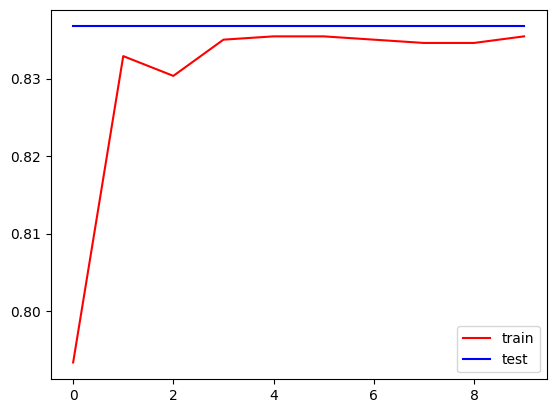

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

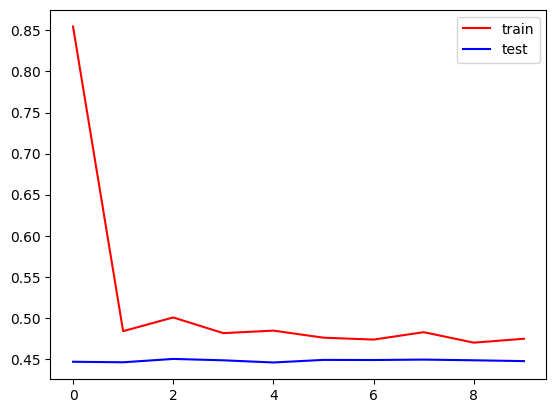

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [46]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(image_test, label_test, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(image_test, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(label_test, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(label_test, predicted_labels))

TESTING DATA:
40/40 - 6s - 140ms/step - accuracy: 0.8278 - loss: 0.4604
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1043
           1       0.00      0.00      0.00       217

    accuracy                           0.83      1260
   macro avg       0.41      0.50      0.45      1260
weighted avg       0.69      0.83      0.75      1260

----CONFUSION MATRICS----
[[1043    0]
 [ 217    0]]
